In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import rfft, rfftfreq
import os
import glob
import pandas as pd

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# --- Configuration ---
directory = "./"  # update to your directory
channel_labels = {"CH1": "Cathode", "CH2": "Trigger", "CH3": "Anode"}
channels_to_process = ["CH1", "CH3"]

# --- File search ---
csv_files = sorted(glob.glob(os.path.join(directory, "Tek*_ALL.csv")))

In [3]:
# --- First pass: find minimum valid length ---
min_valid_length = np.inf

for file in csv_files:
    with open(file, 'r') as f:
        lines = f.readlines()[18:]
    data = np.genfromtxt(lines, delimiter=',')
    if data.shape[1] < 4:
        continue
    time = data[:, 0]
    for i in [1, 3]:  # CH1 and CH3
        signal = data[:, i]
        valid_mask = np.isfinite(time) & np.isfinite(signal)
        if np.sum(valid_mask) >= 2:
            min_valid_length = min(min_valid_length, np.sum(valid_mask))

min_valid_length = int(min_valid_length)
print(f"Using FFT length of {min_valid_length} samples")

# Containers for results
rms_values = {ch: [] for ch in channels_to_process}
fft_accumulators = {ch: None for ch in channels_to_process}
fft_count = {ch: 0 for ch in channels_to_process}
freq_axis = None

Using FFT length of 249996 samples


In [4]:
# --- Second pass: compute FFTs and RMS ---
for file in csv_files:
    try:
        with open(file, 'r') as f:
            lines = f.readlines()[18:]
        data = np.genfromtxt(lines, delimiter=',')
        if data.shape[1] < 4:
            continue
        raw_time = data[:, 0]

        for i, ch in enumerate(["CH1", "CH2", "CH3"]):
            if ch not in channels_to_process:
                continue

            signal = data[:, i + 1]
            valid_mask = np.isfinite(raw_time) & np.isfinite(signal)
            time = raw_time[valid_mask]
            signal = signal[valid_mask]

            if len(time) < min_valid_length:
                print(f"Skipping {channel_labels[ch]} in {file}: not enough clean samples")
                continue

            time = time[:min_valid_length]
            signal = signal[:min_valid_length]

            dt = time[1] - time[0]
            if not np.allclose(np.diff(time), dt, rtol=1e-3):
                print(f"Skipping {channel_labels[ch]} in {file}: non-uniform time step")
                continue

            N = len(time)
            if freq_axis is None:
                freq_axis = rfftfreq(N, dt)

            signal_demeaned = signal - np.mean(signal)
            rms_values[ch].append(np.std(signal_demeaned))

            yf = rfft(signal_demeaned)
            power_spectrum = np.abs(yf) ** 2

            if fft_accumulators[ch] is None:
                fft_accumulators[ch] = power_spectrum
            else:
                fft_accumulators[ch] += power_spectrum
            fft_count[ch] += 1

    except Exception as e:
        print(f"Error processing {file}: {e}")

In [5]:
# --- Compute average spectra ---
avg_power_spectra = {
    ch: fft_accumulators[ch] / fft_count[ch]
    for ch in channels_to_process
    if fft_accumulators[ch] is not None and fft_count[ch] > 0
}

<IPython.core.display.Javascript object>


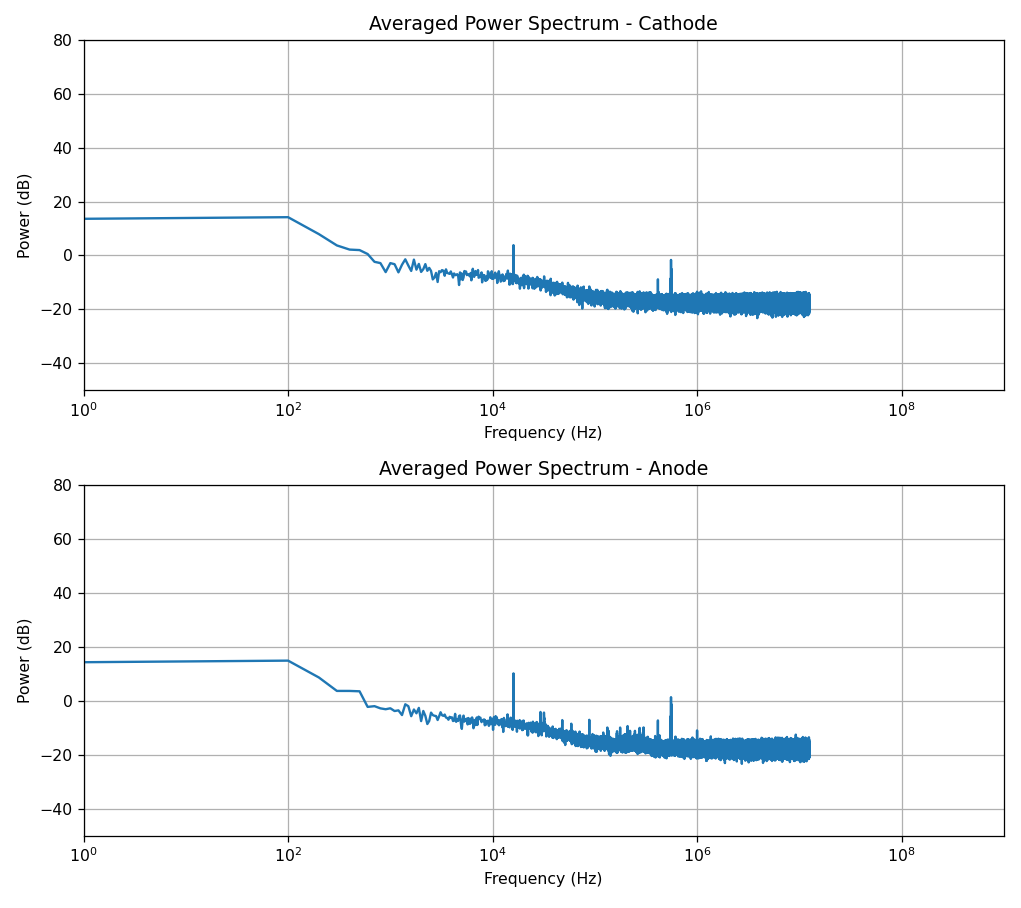

In [6]:
# --- Plot averaged power spectra (separate panels) ---
plt.figure(figsize=(9, 8))
for idx, ch in enumerate(channels_to_process):
    if ch in avg_power_spectra:
        plt.subplot(2, 1, idx + 1)
        plt.xscale('log') # Sets the x-axis to a logarithmic scale
        plt.xlim(1,1000000000)
        plt.ylim(-50, 80)
        plt.plot(freq_axis, 10 * np.log10(avg_power_spectra[ch]))
        plt.title(f"Averaged Power Spectrum - {channel_labels[ch]}")
        plt.xlabel("Frequency (Hz)")
        plt.ylabel("Power (dB)")
        plt.grid(True)
plt.tight_layout()
plt.savefig("averaged_power_spectra.png")
plt.show()

<IPython.core.display.Javascript object>


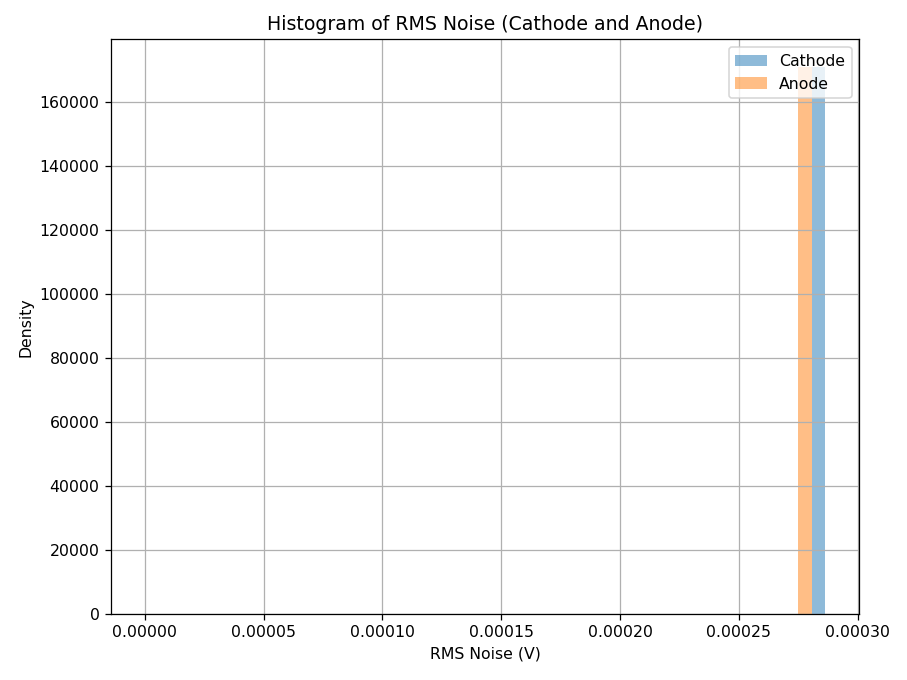

In [7]:
# --- Plot histogram of RMS noise ---
plt.figure(figsize=(8, 6))
all_rms = np.concatenate([rms_values[ch] for ch in channels_to_process if len(rms_values[ch]) > 0])
bins = np.linspace(0, max(all_rms), 50)

for ch in channels_to_process:
    if len(rms_values[ch]) > 0:
        plt.hist(rms_values[ch], bins, alpha=0.5, label=channel_labels[ch], density=True, histtype='stepfilled')

plt.title("Histogram of RMS Noise (Cathode and Anode)")
plt.xlabel("RMS Noise (V)")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("RMS-Noise.png")
plt.show()

In [8]:
# --- Print RMS table ---
rms_table = []
valid_files = min(len(rms_values["CH1"]), len(rms_values["CH3"]))
for i in range(valid_files):
    row = {
        "File": os.path.basename(csv_files[i]),
        "RMS_Cathode": rms_values["CH1"][i],
        "RMS_Anode": rms_values["CH3"][i]
    }
    rms_table.append(row)

rms_df = pd.DataFrame(rms_table)
print("\nRMS Noise Table:")
print(rms_df.to_string(index=False))



RMS Noise Table:
              File  RMS_Cathode  RMS_Anode
Tek000_000_ALL.csv     0.000286   0.000280
Tek000_001_ALL.csv     0.000283   0.000277
Tek000_002_ALL.csv     0.000283   0.000276
Tek000_003_ALL.csv     0.000286   0.000280
Tek000_004_ALL.csv     0.000286   0.000278
Tek000_005_ALL.csv     0.000285   0.000278
Tek000_006_ALL.csv     0.000285   0.000276
Tek000_007_ALL.csv     0.000284   0.000277
Tek000_008_ALL.csv     0.000286   0.000279
Tek000_009_ALL.csv     0.000286   0.000279
Tek000_010_ALL.csv     0.000285   0.000277
Tek000_011_ALL.csv     0.000284   0.000277
Tek000_012_ALL.csv     0.000285   0.000279
Tek000_013_ALL.csv     0.000286   0.000278
Tek000_014_ALL.csv     0.000285   0.000280


<IPython.core.display.Javascript object>


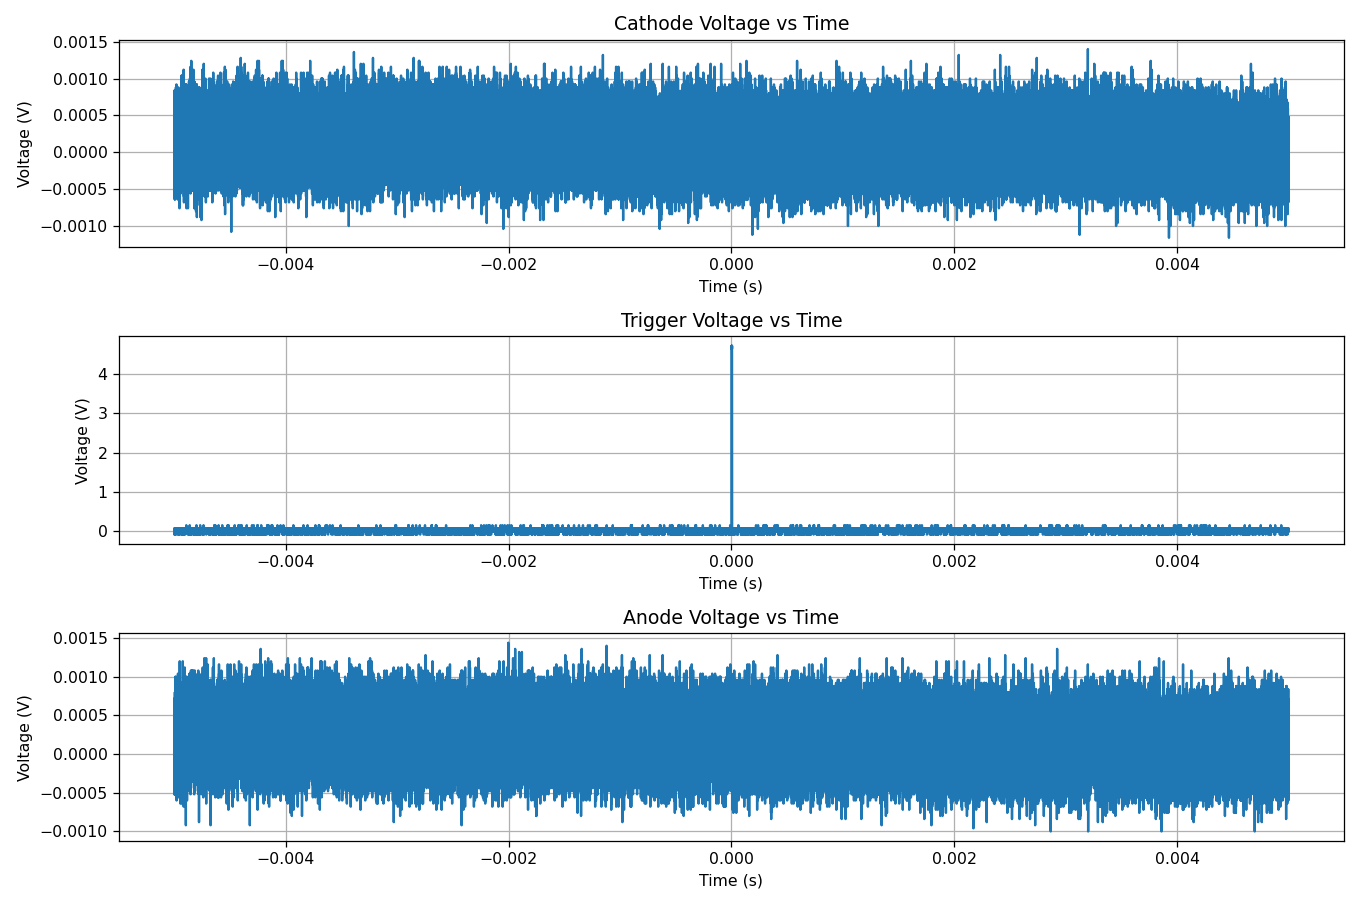

In [9]:
# --- Voltage vs Time for a sample file ---
try:
    sample_file = csv_files[0]
    with open(sample_file, 'r') as f:
        lines = f.readlines()[18:]
    data = np.genfromtxt(lines, delimiter=',')
    raw_time = data[:, 0]

    plt.figure(figsize=(12, 8))
    for i, ch in enumerate(["CH1", "CH2", "CH3"]):
        signal = data[:, i + 1]
        valid_mask = np.isfinite(raw_time) & np.isfinite(signal)
        time = raw_time[valid_mask]
        signal = signal[valid_mask]
        if len(time) < 2:
            print(f"Skipping plot for {channel_labels[ch]}: Too few valid points")
            continue
        plt.subplot(3, 1, i + 1)
        plt.plot(time, signal)
        plt.title(f"{channel_labels[ch]} Voltage vs Time")
        plt.xlabel("Time (s)")
        plt.ylabel("Voltage (V)")
        plt.grid(True)
    plt.tight_layout()
    plt.show()
    plt.savefig("ExampleSpectrum.png")

except Exception as e:
    print(f"Error plotting sample file: {e}")